# **Análisis de Datos de Jidoka en Eje de directa**

<p align="center">
  <img src="..\Imagenes\SR PF.png" alt="SmartRunner Detector">
</p>

## **Introducción**
El sector de SPS (Sistema de Producción SCANIA) recibió la solicitud de detectar virutas en los ejes de dirección.

## **Problema**
Durante el mecanizado de las piezas, pueden desprenderse virutas de hasta 10mm, lo que podría ocasionar graves problemas en la producción si no se detectan a tiempo, incluso deteniendo la máquina.

## **Solución Implementada**
Inicialmente se implementó un sensor SmartRunner, pero se encontraron dificultades durante las pruebas de detección debido al corto alcance del sensor y a la inestabilidad causada por la presencia de luz que se reflejaba en la pieza. Para abordar esto, se decidió colocar otro sensor frente al primero, ampliando así el rango de detección y colocando una superficie blanca en el soporte del sensor, resolviendo así la inestabilidad.

## **Análisis de Datos**
Para un análisis más detallado, se decidió implementar un registro de los resultados obtenidos por los sensores al analizar las piezas. Cuando el gantry deposita la pieza en el soporte, los sensores la analizan y envían los resultados al registro junto con la hora y fecha de la operación.

### **Aclaración**
Mientras tanto, el equipo del Competence Center estaba realizando mejoras en el Jidoka:

* Implementación de pilotos indicadores
* Logica para verificar conexionado
* Mejora del cableado del tablero.
* Reducción de costos en el tablero optimizando el uso de componentes.
* Realización de planos electricos.
* Implementación del **MPO (Mantenimiento Programado para el Operario)**, que incluye la limpieza de los sensores dos veces por semana (martes y viernes).


In [60]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.2, style="whitegrid")

In [61]:
data = pd.read_csv("Directa_DataLoggerC.csv")
data = data.drop(columns=["Record"])

Primeras piezas registradas con el sistema Datalogger

In [62]:
data.head(2)

,Date,LOC Time,RS482,Profinet,Conexion Profinet,Quality A,Quality B,Quality C
0,2024-05-17,15:04:56,0,0,0,86.184659,72.019481,100.078810
1,2024-05-17,15:11:23,0,0,0,91.678694,73.784685,88.736684


Ultimos registros obtenidos

In [63]:
data.tail(2)

,Date,LOC Time,RS482,Profinet,Conexion Profinet,Quality A,Quality B,Quality C
1444,2024-06-11,14:23:01,0,0,0,89.0,65.0,90.0
1445,2024-06-11,14:29:37,1,0,0,89.0,64.0,90.0


## **Proceso de Jidoka**

El resultado final del Jidoka se basa en una secuencia de acciones diseñadas para garantizar la detección y respuesta adecuada ante la presencia de virutas en los ejes de dirección.

### **Pasos del Proceso:**

1. **Verificación de Conexiones de Sensores:**
   Antes de iniciar el proceso de producción, se verifica la correcta conexión de los sensores.

2. **Detección de Virutas por Sensores:**
   Una vez que las conexiones de los sensores han sido verificadas, se procede a la condición de detección. Si alguno de los sensores detecta la presencia de una viruta, se activa un sistema de señalización.

3. **Respuesta Automatizada del Sistema:**
   Cuando se detecta una viruta, el sistema envía una señal al gantry para detener su movimiento. Además, se activa una sirena y una baliza como señales visuales y acústicas.

4. **Intervención del Operario:**
   Antes de reanudar el movimiento del gantry y continuar con el proceso de producción, el operario debe presionar un botón para habilitar la operación. Esto garantiza una verificación manual y la confirmación de que la situación ha sido resuelta antes de continuar.



In [64]:
data["Resultado"] = (data["RS482"] | data["Profinet"]) & ~data["Conexion Profinet"]

In [65]:
def error_detector(sensor_data, name):
    if 1 in sensor_data:
        print(f"Hay errores en el sensor {name}")
    else:
        print(f"No hay errores en el sensor {name}")


In [66]:
error_detector(sensor_data=data["RS482"], name="RS482")
error_detector(sensor_data=data["Profinet"], name="Profinet")

Hay errores en el sensor RS482
Hay errores en el sensor Profinet


In [67]:
print("El Jidoka registro la producción de", data["Profinet"].count(),"piezas.")

El Jidoka registro la producción de 1446 piezas.


In [68]:
## Conversión de datos para luego convertir el dato en un formato Datetime
data["Date"] = data["Date"].astype('str')
data["LOC Time"] = data["LOC Time"].astype('str')
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['LOC Time'])

## data = data.drop(columns=['Date','LOC Time',"Record"])

## Calculo y formato entre fechas y horarios
data["Week"] = data['DateTime'].dt.isocalendar().week
data['Day'] = data['DateTime'].dt.day_name()
data['Diff'] = data['DateTime'].diff()

data.head(2)

,Date,LOC Time,RS482,Profinet,Conexion Profinet,Quality A,Quality B,Quality C,Resultado,DateTime,Week,Day,Diff
0,2024-05-17,15:04:56,0,0,0,86.184659,72.019481,100.078810,0,2024-05-17 15:04:56,20,Friday,NaT
1,2024-05-17,15:11:23,0,0,0,91.678694,73.784685,88.736684,0,2024-05-17 15:11:23,20,Friday,0 days 00:06:27


In [69]:
conexion_profinet_count = data.groupby("Week")["Conexion Profinet"].count().reset_index()
conexion_profinet_count = conexion_profinet_count.rename(columns={"Conexion Profinet": "Cantidad Producida"})

week_gp = data.groupby('Week')[['RS482', 'Profinet',"Conexion Profinet","Resultado"]].sum()

week_gp = week_gp.merge(conexion_profinet_count, how="left", left_index=True, right_on="Week")
week_gp["Piezas OK"] = week_gp["Cantidad Producida"] - week_gp["Resultado"]

week_gp.set_index('Week', inplace=True)

week_gp.head()

,RS482,Profinet,Conexion Profinet,Resultado,Cantidad Producida,Piezas OK
Week,,,,,,
20,0,0,0,0,124,124
21,37,11,0,46,633,587
22,12,2,11,5,149,144
23,25,7,0,31,339,308
24,26,7,0,31,201,170


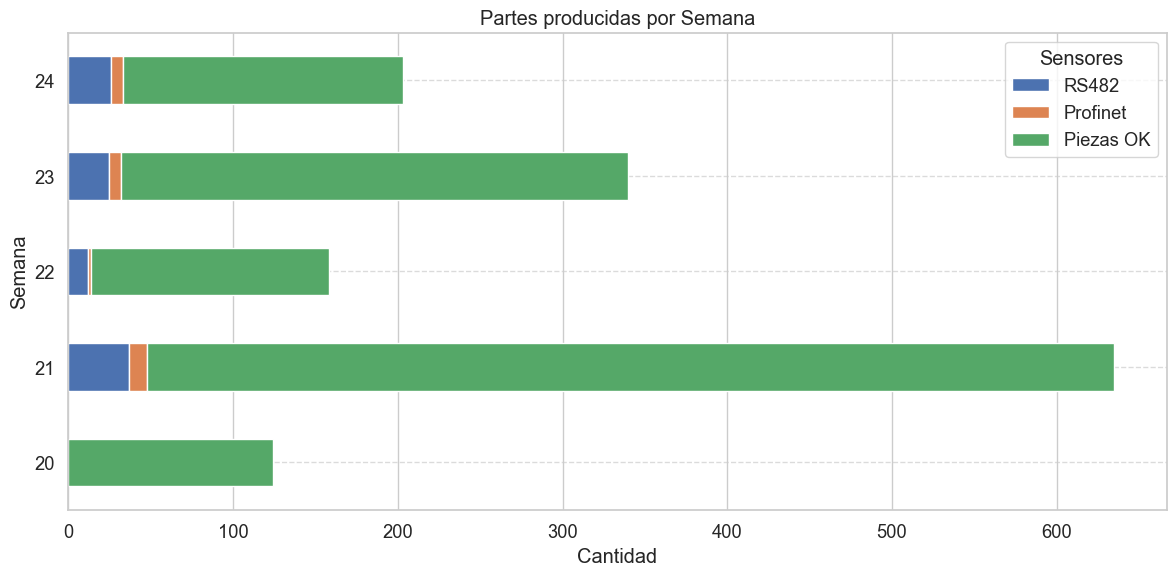

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))
week_gp[['RS482', 'Profinet',"Piezas OK"]].plot(kind='barh', stacked=True, ax=ax)
ax.set_xlabel('Cantidad')
ax.set_ylabel('Semana')
ax.set_title('Partes producidas por Semana')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Sensores')
plt.show()

### **Semanas:**

* **Semana 20**
  - Se realizó la implementación del registro en sistema de detección de virutas en los ejes de dirección.

* **Semana 21**
  - Se completó el registro de datos con el MPO (Mantenimiento Programado para el Operario) realizado correctamente, asegurando un seguimiento preciso de las detecciones de virutas.

* **Semana 22**
  - Aunque el sistema estaba en funcionamiento, se registró una disminución en la eficiencia durante esta semana. Esto se debió a que el MPO no se realizó el día viernes, lo que resultó en una detección reducida de virutas. Como consecuencia, el sistema se detuvo temporalmente debido a la activación de múltiples falsos positivos.

* **Semana 23**
  - La semana actual se encuentra en progreso, con el equipo trabajando para recuperar la eficiencia del sistema y garantizar que todas las operaciones planificadas, incluido el MPO, se lleven a cabo según lo programado.


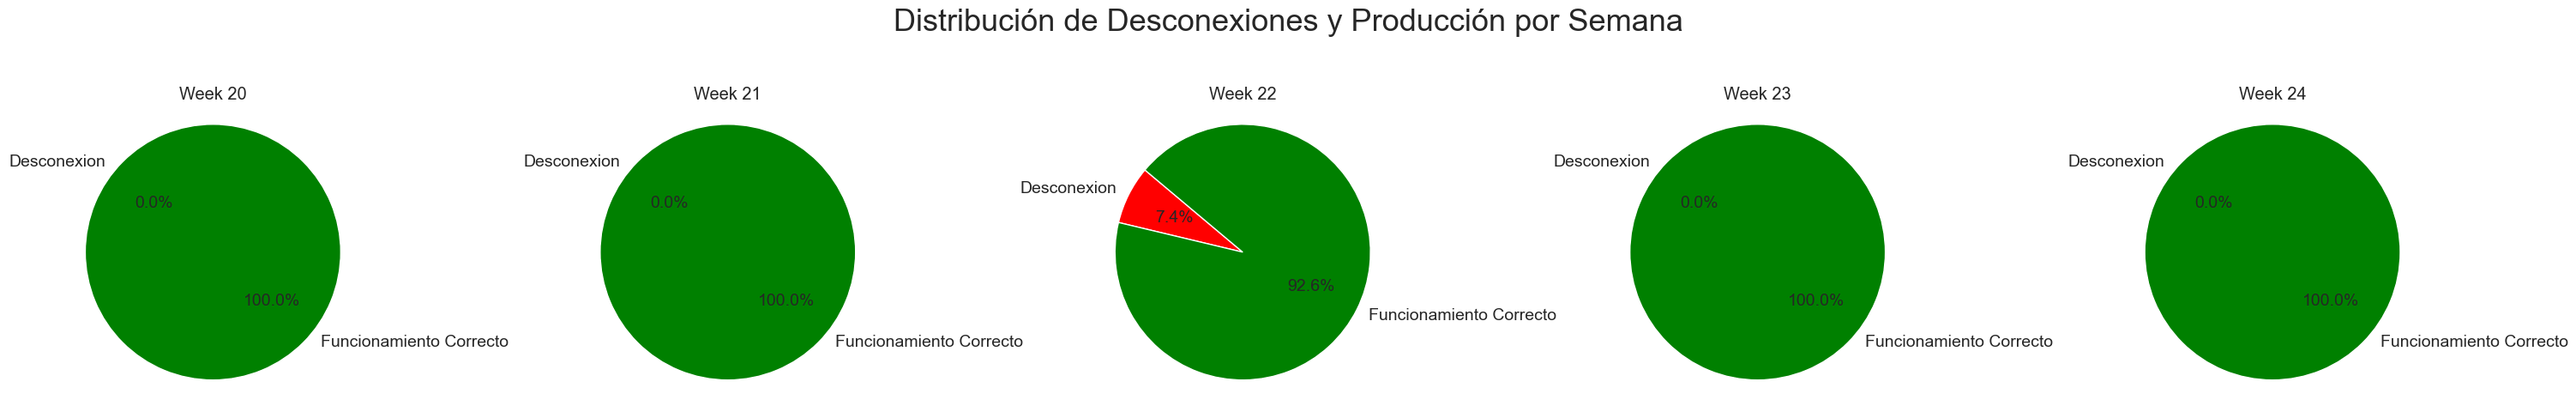

In [71]:
week_pie = week_gp[['Conexion Profinet', 'Resultado', 'Cantidad Producida']].copy()
week_pie['Funcionamiento Correcto'] = week_pie['Cantidad Producida'] - week_pie['Conexion Profinet']
week_pie = week_pie.rename(columns={"Conexion Profinet": "Desconexion"})

fig, axs = plt.subplots(1, 5, figsize=(30, 5))

colors = ['red', 'green']

for ax, (week, row) in zip(axs, week_pie.iterrows()):
    labels = ['Desconexion', 'Funcionamiento Correcto']
    sizes = [row['Desconexion'], row['Funcionamiento Correcto']]
    ax.pie(sizes, labels=labels, startangle=140, colors=colors, textprops={'fontsize': 14}, radius=1.1, autopct='%1.1f%%')
    ax.set_title(f'Week {week}')

plt.suptitle('Distribución de Desconexiones y Producción por Semana', fontsize=26)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

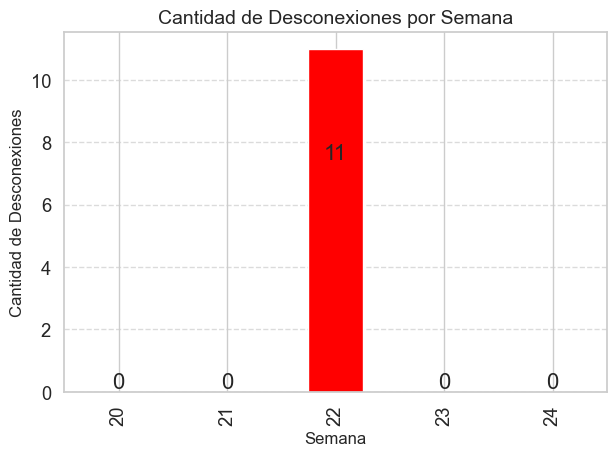

In [72]:
disconnections_per_week = data.groupby('Week')['Conexion Profinet'].sum()
ax = disconnections_per_week.plot(kind='bar', stacked=True, color='red')

for i, value in enumerate(disconnections_per_week):
    ax.text(i, value/1.5, str(value), ha='center', va='bottom', fontsize=16)

plt.title('Cantidad de Desconexiones por Semana', fontsize=14)
plt.xlabel('Semana', fontsize=12)
plt.ylabel('Cantidad de Desconexiones', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout()
plt.show()

**Semana 22**
  - Durante esta semana, se implementó una mejora en el cableado del sistema con el objetivo de optimizar su funcionamiento y estandarizar las conexiones. Sin embargo, durante esta mejora, hubo una brecha temporal en la detección de virutas, lo que resultó en un mal funcionamiento del sistema. Es importante destacar que este problema no se repitió en el tiempo y se consideraría ***resuelto***.

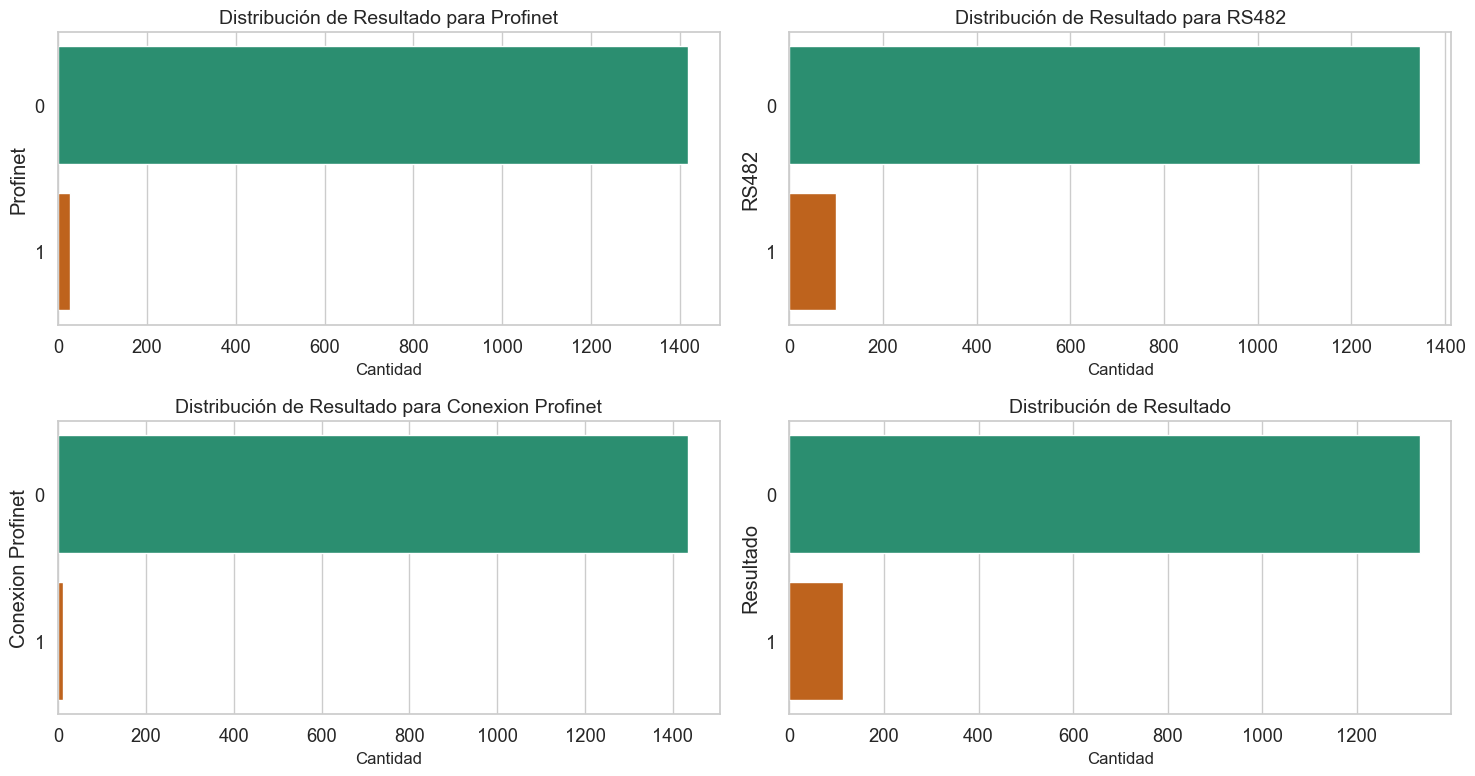

In [73]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

sns.countplot(y=data["Profinet"], ax=axs[0, 0], palette="Dark2")
sns.countplot(y=data["RS482"], ax=axs[0, 1], palette="Dark2")
sns.countplot(y=data["Conexion Profinet"], ax=axs[1, 0], palette="Dark2")
sns.countplot(y=data["Resultado"], ax=axs[1, 1], palette="Dark2")

axs[0, 0].set_title('Distribución de Resultado para Profinet', fontsize=14)
axs[0, 1].set_title('Distribución de Resultado para RS482', fontsize=14)
axs[1, 0].set_title('Distribución de Resultado para Conexion Profinet', fontsize=14)
axs[1, 1].set_title('Distribución de Resultado', fontsize=14)

for ax in axs.flat:
    ax.set_xlabel('Cantidad', fontsize=12)

plt.tight_layout()
plt.show()

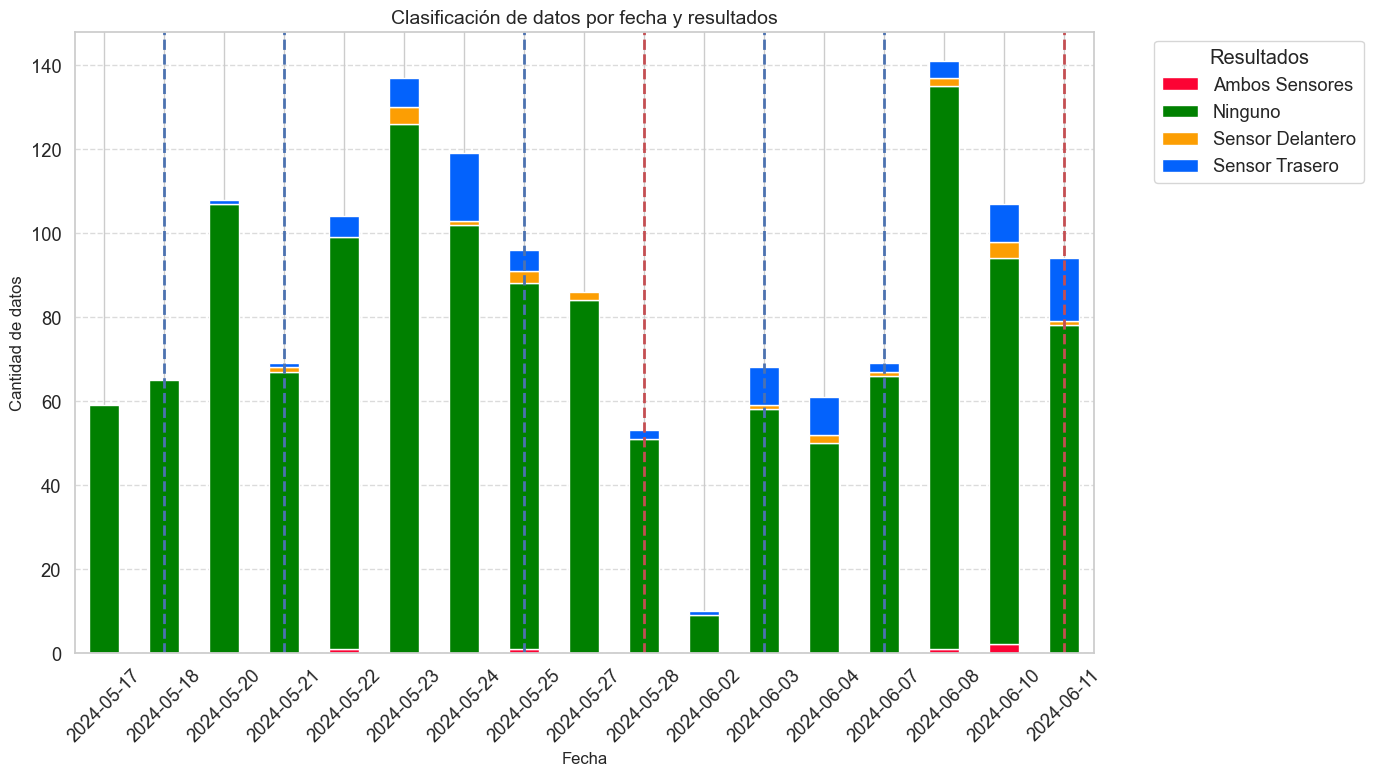

In [74]:
def clasificar(row):
    if (row['RS482'] == 1 or row['Profinet'] == 1) and row['Conexion Profinet'] == 0:
        if row['RS482'] == 1 and row['Profinet'] == 1:
            return 'Ambos Sensores'
        elif row['RS482'] == 1:
            return 'Sensor Trasero'
        elif row['Profinet'] == 1:
            return 'Sensor Delantero'
    else:
        return 'Ninguno'

data['Resultados'] = data.apply(clasificar, axis=1)
data_counts = data.groupby(['Date', 'Resultados']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(14, 8))

## Ambos Sensores, Ninguno, Sensor Delantero, Sensor Trasero
colors = ['#FC0334', '#008000', '#FC9E03', '#0362FC']

data_counts.plot(kind='bar', stacked=True, ax=ax, color=colors)

## Lineas indicadoras de MPO
mpo_date = [1,3,7,11,13]
for date in mpo_date:
    plt.axvline(x=date, color='b', linestyle='--',linewidth=2)

no_mpo_date = [9,16]
for date in no_mpo_date:
    plt.axvline(x=date, color='r', linestyle='--',linewidth=2)

ax.legend(title='Resultados', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Clasificación de datos por fecha y resultados', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cantidad de datos', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **Conclusiones**